### Extract numpy array from dicoms

In [1]:
import os
import glob
import pydicom
import subprocess
import numpy
import matplotlib.pyplot as plt

def clearFolder(path):
    files = glob.glob(path+'*')
    for f in files:
        os.remove(f)

def extractDicoms(path, out, start, folderClass, slices):
    if not os.path.exists(tmp):
        os.makedirs(tmp)
    else:
        clearFolder(tmp)

    if not os.path.exists(out):
        os.makedirs(out)
    elif start == 0:
        clearFolder(out)

    i = start
    for dirpath, dirs, files in os.walk(path):
        firstFile = os.listdir(dirpath)[0]
        if '.dcm' in firstFile:
            dicomCounter = len(glob.glob1(dirpath,"*.dcm"))
            if dicomCounter > 99:
                ds = pydicom.read_file(os.path.join(dirpath,firstFile))
                # Filter dicoms with "Head" in Protocol Name
                if hasattr(ds, 'ProtocolName') and hasattr(ds, 'PixelSpacing') and 'Head' in ds.ProtocolName:
                    fileList = glob.glob1(dirpath,"*.dcm")
                    lstFilesDCM = []

                    for filename in fileList:
                        subprocess.check_output(['gdcmconv','--raw',dirpath+'/'+filename,tmp+filename])
                        lstFilesDCM.append(os.path.join(tmp,filename))

                    # Get ref file
                    RefDs = pydicom.read_file(lstFilesDCM[0])

                    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
                    #ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
                    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), slices)

                    # Load spacing values (in mm)
                    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
                    # The array is sized based on 'ConstPixelDims'
                    ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

                    # loop through all the DICOM files
                    for filenameDCM in lstFilesDCM:
                        ds = pydicom.read_file(filenameDCM)
                        if ds.InstanceNumber <= slices:
                            ArrayDicom[:, :, ds.InstanceNumber - 1] = ds.pixel_array
                    output = (ArrayDicom, folderClass)
                    numpy.save(out + str(i), output)
                    #print('Processed ' + str(i) + ': ' + str(dicomCounter) + ' : ' + str(folderClass) + ' : ' + dirpath.replace(path, ""))
                    clearFolder(tmp)
                    i = i + 1

#### Normal dicoms

In [2]:
start = 0
folderClass = 0
slices = 350

path = '/home/victor/Downloads/exames/normais'
tmp = '/home/victor/Downloads/exames/tmp/'
out = '/home/victor/Downloads/exames/data/{}/'.format(folderClass)

extractDicoms(path, out, start, folderClass, slices)

#### Abnormal dicoms

In [3]:
start = 160
folderClass = 1
slices = 350

path = '/home/victor/Downloads/exames/alterados'
tmp = '/home/victor/Downloads/exames/tmp/'
out = '/home/victor/Downloads/exames/data/{}/'.format(folderClass)

extractDicoms(path, out, start, folderClass, slices)

#### Show some random data

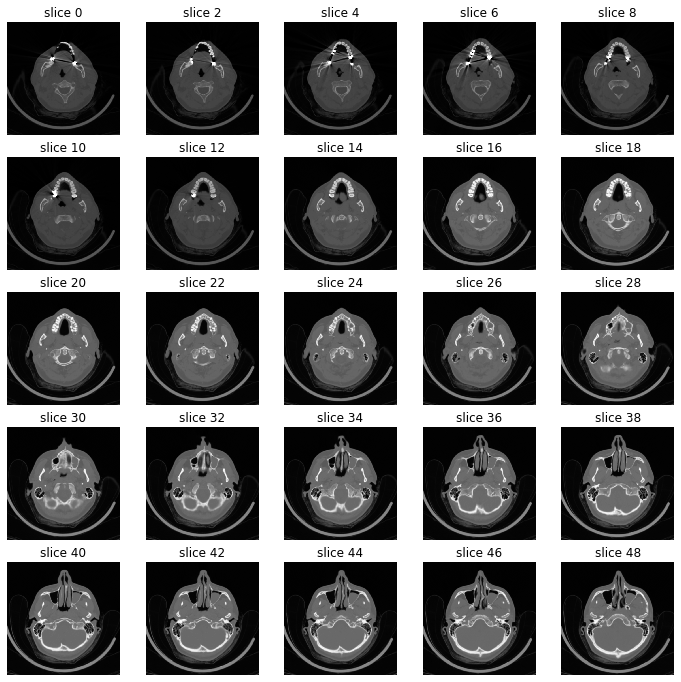

In [4]:
def showDicom(id, rows=5, cols=5, start_with=0, show_every=2):
    stack = numpy.load('/home/victor/Downloads/exames/data/0/{}.npy'.format(id),  allow_pickle=True)
    stack = stack[0]
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[:,:,ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

showDicom(50)

### Train Model using Tensorflow
I recommend saving the following code as train.py because Jupyter for some reason is crashing.

In [5]:
import os
import re
import hashlib
import argparse
import numpy as np
import tensorflow as tf
import glob
import six
import datetime
import time
import utils

from tensorflow.python.platform import gfile
from keras.utils import (np_utils, to_categorical)
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

MODEL_NUM = 4
EPOCHS_WITHOUT_IMPROVEMENT = 15
SAVE_PATH = "./output/model_" + str(MODEL_NUM) + "/tf-model.ckpt"

RANDOM_SEED = 42

NUM_CLASSES = 2
VALID_IMAGE_FORMATS = frozenset(['npy'])
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M

BATCH_SIZE = 2
LEARNING_RATE = 0.00001
EPOCHS = 25
DROP_RATE = 0.50

MODEL_INPUT_HEIGHT = 512
MODEL_INPUT_WIDTH = 512
MODEL_INPUT_DEPTH = 350
MODEL_N_CHANNELS = 1

def cnn_model(x_train_data, drop_rate=0.0, batch_size=1, seed=None):
    with tf.name_scope("layer_0"):
        pool0 = tf.layers.max_pooling3d(inputs=x_train_data, pool_size=[2, 2, 2], strides=2)

        conv1 = tf.layers.conv3d(inputs=pool0, filters=12, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling3d(inputs=conv1, pool_size=[2, 2, 2], strides=2)

        conv2 = tf.layers.conv3d(inputs=pool1, filters=32, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 2, 2], strides=2)

        conv3 = tf.layers.conv3d(inputs=pool2, filters=64, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling3d(inputs=conv3, pool_size=[2, 2, 2], strides=2)

        conv4 = tf.layers.conv3d(inputs=pool3, filters=128, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        pool4 = tf.layers.max_pooling3d(inputs=conv4, pool_size=[2, 2, 2], strides=2)

        conv5 = tf.layers.conv3d(inputs=pool4, filters=256, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        pool5 = tf.layers.max_pooling3d(inputs=conv5, pool_size=[2, 2, 2], strides=2)

        cnn3d = pool5

    with tf.name_scope("fully_con"):
        flattening = tf.reshape(cnn3d, [-1, cnn3d.shape[1]*cnn3d.shape[2]*cnn3d.shape[3]*cnn3d.shape[4]])
        dense1 = tf.layers.dense(inputs=flattening, units=2048, activation=tf.nn.relu)
        dropout1 = tf.layers.dropout(inputs=dense1, rate=drop_rate, training=True)
        dense2 = tf.layers.dense(inputs=dropout1, units=512, activation=tf.nn.relu)
        dropout2 = tf.layers.dropout(inputs=dense2, rate=drop_rate, training=True)

    with tf.name_scope("y_conv"):
        y_conv = tf.layers.dense(inputs=dropout2, units=2)

    return y_conv

def train_cnn(reload_model, image_dir, samples_train, samples_val, learning_rate=0.0001, num_classes=2, epochs_without_improvement=5, batch_size=1, image_shape=(512, 512, 350, 1)):
    with tf.name_scope('inputs'):
        x_input = tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2], image_shape[3]], name='x_input')
        y_input = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')
        drop_rate = tf.placeholder(tf.float32, shape=(None), name='drop_rate')

    with tf.name_scope("cross_entropy"):
        prediction = cnn_model(x_input, drop_rate, batch_size=batch_size, seed=1)
        prediction = tf.identity(prediction, name='prediction')
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_input), name='cost')

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_input, 1))
    correct = tf.identity(correct, name='correct')
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    accuracy = tf.identity(accuracy, name='accuracy')

    iterations = int(len(samples_train)/batch_size)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            total_parameters += variable_parameters
        print("Total parameters: {}".format(total_parameters))

        if reload_model:
            print("Reloading model {}".format(SAVE_PATH))
            saver.restore(sess, tf.train.latest_checkpoint('./'))
        else:
            sess.run(tf.global_variables_initializer())

        start_time = datetime.datetime.now()

        highest_val_acc = 0
        count_highest_val_acc = 0
        # run epochs
        #for epoch in range(epochs):
        epoch = 0
        while True:
            #print("[{}] Epoch {}/{}".format(time.strftime("%Y-%m-%d %H:%M:%S"), epoch+1, epochs))
            print("[{}] Epoch {}".format(time.strftime("%Y-%m-%d %H:%M:%S"), epoch+1))
            utils.progress(0, iterations, 0, 0, 0, 0, new_line=True)

            start_time_epoch = datetime.datetime.now()

            # Randomize data
            np.random.shuffle(samples_train)

            epoch_loss = 0
            epoch_acc = 0
            # mini batch
            for itr in range(iterations):
                samples_batch = samples_train[itr*batch_size:(itr+1)*batch_size]

                if len(samples_batch) == batch_size:
                    batch_x = np.zeros((batch_size,) + image_shape, dtype=np.float32)
                    batch_y = np.zeros((len(batch_x), num_classes), dtype=np.float32)
                    for i, idx in enumerate(samples_batch):
                        data = np.load(image_dir + '/' + idx[0], allow_pickle=True)
                        x = np.expand_dims(data[0], axis=3)
                        batch_x[i] = x
                        batch_y[i] = to_categorical(idx[1], num_classes=num_classes)

                    _acc, _optimizer, _cost = sess.run([accuracy, optimizer, cost], feed_dict={x_input: batch_x, y_input: batch_y, drop_rate: DROP_RATE})

                    epoch_acc = epoch_acc + _acc
                    epoch_loss = epoch_loss + _cost

                    utils.progress(itr+1, iterations, _cost, _acc, epoch_loss/(itr+1), epoch_acc/(itr+1))
                    #print("{}: {}/{} [{}] training loss: {}".format(time.strftime("%Y-%m-%d %H:%M:%S"), epoch+1, epochs, itr+1, iterations, _cost), end='\r')

            #  using mini batch in case not enough memory
            batch_size = 1
            acc = 0
            itrs = int(len(samples_val)/batch_size)
            for itr in range(itrs):
                samples_batch = samples_val[itr*batch_size:(itr+1)*batch_size]

                if len(samples_batch) == batch_size:
                    batch_x = np.zeros((batch_size,) + image_shape, dtype=np.float32)
                    batch_y = np.zeros((len(batch_x), num_classes), dtype=np.float32)
                    for i, idx in enumerate(samples_batch):
                        data = np.load(image_dir + '/' + idx[0], allow_pickle=True)
                        x = np.expand_dims(data[0], axis=3)
                        batch_x[i] = x
                        batch_y[i] = to_categorical(idx[1], num_classes=num_classes)

                    acc += sess.run(accuracy, feed_dict={x_input: batch_x, y_input: batch_y, drop_rate: 0})
                    #print("Validation itr: {} accuracy: {}".format(itr, accuracy))

            end_time_epoch = datetime.datetime.now()
            val_acc = acc/itrs
            if val_acc > highest_val_acc:
                highest_val_acc = val_acc
                count_highest_val_acc = 0
                print("[{}] Highest Val. Acc: {} - Time elapsed: {}".format(time.strftime("%Y-%m-%d %H:%M:%S"), val_acc, str(end_time_epoch - start_time_epoch)))

                # Save Model
                save_path = saver.save(sess, SAVE_PATH)
            else:
                count_highest_val_acc = count_highest_val_acc + 1
                print("[{}] {} Epochs without improvement - Current Val. Acc: {} - Time elapsed: {}".format(time.strftime("%Y-%m-%d %H:%M:%S"), count_highest_val_acc, val_acc, str(end_time_epoch - start_time_epoch)))

                if count_highest_val_acc == epochs_without_improvement:
                    print("[{}] Stoping training...".format(time.strftime("%Y-%m-%d %H:%M:%S")))
                    break;

            epoch = epoch + 1;



        end_time = datetime.datetime.now()
        print('Time elapsed: ', str(end_time - start_time))

        # Save Model
        #save_path = saver.save(sess, SAVE_PATH)

def main(train, image_dir, validation_pct, test_pct, reload_model):
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)]
    num_classes = len(sub_dirs) - 1
    print("Number of classes found: {}".format(num_classes))

    filenames = utils.create_image_list(image_dir, VALID_IMAGE_FORMATS, MAX_NUM_IMAGES_PER_CLASS)
    filenames = shuffle(filenames, random_state=RANDOM_SEED)

    print("Found {} files".format(len(filenames)))

    val_len = int(len(filenames)*validation_pct/100)
    test_len = int(len(filenames)*test_pct/100)
    train_len = len(filenames) - val_len - test_len

    print("train: {}, validate: {}, test: {}, ".format(train_len, val_len, test_len))

    samples_train = filenames[:train_len]
    samples_val = filenames[train_len:train_len+val_len]
    samples_test = filenames[train_len+val_len:]

    if train:
        # Train model
        train_cnn(reload_model, image_dir, samples_train, samples_val,
                            num_classes=NUM_CLASSES,
                            #epochs=EPOCHS,
                            epochs_without_improvement=EPOCHS_WITHOUT_IMPROVEMENT,
                            batch_size=BATCH_SIZE,
                            learning_rate=LEARNING_RATE,
                            image_shape=(MODEL_INPUT_HEIGHT, MODEL_INPUT_WIDTH, MODEL_INPUT_DEPTH, MODEL_N_CHANNELS))

    # Test model
    image_shape = (MODEL_INPUT_HEIGHT, MODEL_INPUT_WIDTH, MODEL_INPUT_DEPTH, MODEL_N_CHANNELS)
    batch_size = 1

    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(SAVE_PATH + '.meta')
        loader.restore(sess, SAVE_PATH)

        # Get Tensors from loaded model
        x_input = loaded_graph.get_tensor_by_name('inputs/x_input:0')
        y_input = loaded_graph.get_tensor_by_name('inputs/y_input:0')
        drop_rate = loaded_graph.get_tensor_by_name('inputs/drop_rate:0')
        prediction = loaded_graph.get_tensor_by_name('cross_entropy/prediction:0')
        correct = loaded_graph.get_tensor_by_name('correct:0')
        accuracy = loaded_graph.get_tensor_by_name('accuracy:0')

        start_time_epoch = datetime.datetime.now()

        #  using mini batch in case not enough memory
        acc = 0
        itrs = int(len(samples_test)/batch_size)
        print("itrs: {}".format(itrs))
        y_real = []
        y_pred = []
        for itr in range(itrs):
            samples_batch = samples_test[itr*batch_size:(itr+1)*batch_size]

            if len(samples_batch) == batch_size:
                batch_x = np.zeros((batch_size,) + image_shape, dtype=np.float32)
                batch_y = np.zeros((len(batch_x), num_classes), dtype=np.float32)

                for i, idx in enumerate(samples_batch):
                    data = np.load(image_dir + '/' + idx[0], allow_pickle=True)
                    x = np.expand_dims(data[0], axis=3)
                    batch_x[i] = x
                    batch_y[i] = to_categorical(idx[1], num_classes=num_classes)

                pred_value = sess.run(prediction, feed_dict={x_input: batch_x, drop_rate: 0.})
                real_class = np.argmax(batch_y, 1)
                pred_class = np.argmax(pred_value, 1)

                y_real.append(real_class)
                y_pred.append(pred_class)

                success = False
                if real_class == pred_class:
                    success = True
                    acc = acc + 1
                    #print("[SUCC] {}: {} {}".format(samples_batch, pred_value, sess.run(tf.nn.softmax(pred_value))))
                else:
                    print("[FAIL] {}: {} {}".format(samples_batch, pred_value, sess.run(tf.nn.softmax(pred_value))))
                #print("itr: {} real: {} prediction: {} success: {}".format(itr, real_class, pred_class, success))

        end_time_epoch = datetime.datetime.now()
        print('Test Accuracy:', acc/itrs, ' Time elapse: ', str(end_time_epoch - start_time_epoch))
        print(confusion_matrix(y_real, y_pred))

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', default=False, help='train model')
    parser.add_argument('--image-dir', default='data', help='data directory')
    parser.add_argument('--validation-pct', default=10, help='validation percentage')
    parser.add_argument('--test-pct', default=10, help='test percentage')
    parser.add_argument('--reload_model', default=False, help='reload model')

    args = parser.parse_args()

    os.makedirs('./output/', exist_ok=True)

    main(**vars(args))	

[2019-08-14 10:07:59] Epoch 1
[2019-08-14 12:24:56] 141/141 [=========================] - acc: 0.5000 - loss: 11.8061 - total acc: 0.5638 - total loss: 45.8806
[2019-08-14 12:26:13] Highest Val. Acc: 0.6285714285714286 - Time elapsed: 2:18:14.079960
[2019-08-14 12:26:15] Epoch 2
[2019-08-14 13:36:58] 141/141 [=========================] - acc: 1.0000 - loss: 0.0000 - total acc: 0.5745 - total loss: 31.0583
[2019-08-14 13:38:18] 1 Epochs without improvement - Current Val. Acc: 0.5142857142857142 - Time elapsed: 1:12:03.571928
[2019-08-14 13:38:18] Epoch 3
[2019-08-14 14:50:11] 141/141 [=========================] - acc: 0.0000 - loss: 2.1299 - total acc: 0.5745 - total loss: 16.3413
[2019-08-14 14:51:33] Highest Val. Acc: 0.6571428571428571 - Time elapsed: 1:13:14.789791
[2019-08-14 14:51:35] Epoch 4
[2019-08-14 16:02:10] 141/141 [=========================] - acc: 0.0000 - loss: 6.2391 - total acc: 0.5390 - total loss: 10.9933
[2019-08-14 16:03:27] 1 Epochs without improvement - Current V